# MLCv2 2D w Params

In [5]:
import os
import numpy as np
import cv2

##### Function Block #####
#Function to generate an MLC image
def generate_image(leaf, retraction, img): #Input Format: (Leaf #, retraction from 0 (closed) to 1 (open)) 
   
    
    #Fixed mechanical specifications of MLCv2 2D
    leaf_width = 180 #representing 1.8mm
    leaf_gap = 80 #0.1mm gap
    y_range = 1600 # The leaves have a ~26mm range of motion
    y_gap = 40 # a 0.1mm gap between top and bottom
    
    x_start = (530 + (leaf - 1)*(leaf_width+leaf_gap))
    bot_x_start = (530 + (leaf - 27)*(leaf_width+leaf_gap))
    
    #Write 0s for leaves (y_start : y_stop , x_start : x_stop)
    if leaf <= 26:
        img[400 : int((3000 - y_gap) - retraction*y_range) , x_start : (x_start + leaf_width)] = 0
    elif 27 <= leaf <= 52:
        img[int((3000 + y_gap) + retraction*y_range) : 5600  , bot_x_start : (bot_x_start + leaf_width)] = 0
    else:
        print("Error: Leaf is not in the valid range")
            
    return img
            
#Function to write img as bpm
def save_bitmap(filename, img):
    with open(filename, "w") as f:
        f.write("P1\n6000 6000\n")
        for row in img:
            f.write(" ".join(str(x) for x in row) + "\n")

# Generate corresponding png and scale down by scaling factor
def save_png(filename, img, scale_factor):
    img_scaled = cv2.resize(img, (img.shape[1] // scale_factor, img.shape[0] // scale_factor), interpolation=cv2.INTER_NEAREST)
    img_scaled = (img_scaled == 0) * 255
    cv2.imwrite(filename, img_scaled)

##### Output Destination #####
#Where to save the bpm and png outputs
output_folder = "mask_output"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Parameters
scale_factor = 10    
    
##### Input: Specify Mask #####
#Specifiy mask with array of 40 entries ranging between 0 and 1 (precision to 4 figures)
#where 0 represents no retraction and 1 represents full retraction
#The i'th entry specifies the retraction of the i'th leaf counting 
#from top left to top right then bottom left to bottom right           
leaf_params = [
    0.000, 0.000, 0.000, 0.250, 0.250, 0.250, 0.250, 0.000, 0.000, 0.000, 
    0.800, 0.740, 0.680, 0.620, 0.560, 0.500, 0.440, 0.380, 0.320, 0.260, 
    0.200, 0.140, 0.080, 0.020, 0.000, 0.000, 
    
    0.000, 0.000, 0.000, 0.250, 0.250, 0.250, 0.250, 0.000, 0.000, 0.000, 
    0.800, 0.740, 0.680, 0.620, 0.560, 0.500, 0.440, 0.380, 0.320, 0.260, 
    0.200, 0.140, 0.080, 0.020, 0.000, 0.000,
]


 #Initialize base image, representing fully open MLC
img = np.zeros((6000, 6000), dtype=np.uint8)
img[400:5600, 520:5470] = 1


# Apply leaf extensions
for i, retraction in enumerate(leaf_params):
    leaf = i + 1
    generate_image(leaf, retraction, img)


# Save the final image as a bitmap and PNG
bitmap_filename = os.path.join(output_folder, "JohnMask_8x_gap.pbm")
save_bitmap(bitmap_filename, img)

png_filename = os.path.join(output_folder, "JohnMask_8x_gap.png")
save_png(png_filename, img, scale_factor)

# BitMaps From MATLAB

In [2]:
import os
import numpy as np
import cv2
from scipy.io import loadmat

# Function to save img as bitmap
def save_bitmap(filename, img):
    cv2.imwrite(filename, img, [cv2.IMWRITE_PXM_BINARY, 1]) 

# Generate corresponding png and scale down by scaling factor
def save_png(filename, img, scale_factor):
    img_scaled = cv2.resize(img, (img.shape[1] // scale_factor, img.shape[0] // scale_factor), interpolation=cv2.INTER_NEAREST)
    img_scaled = (img_scaled == 0) * 255  # Scale the pixel values
    img_inverted = 255 - img_scaled  # Invert the image
    cv2.imwrite(filename, img_inverted)

# Specify the .mat file path here
mat_file_path = "masks_1degTilt.mat" 

# Load .mat file
mat = loadmat(mat_file_path) 

# Load the 3D data array
data_3d = mat['Expression1'] 

# Scale factor
scale_factor = 1

# Output folder
output_folder = "Nathans_mask_output_1deg"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# For each 2D slice in the 3D array
for i in range(data_3d.shape[0]):
    # Extract 2D slice
    img = data_3d[i, :, :]

    # Save the final image as a bitmap and PNG
    bitmap_filename = os.path.join(output_folder, f"MLCv2-Mask_{i+1}.pbm")
    save_bitmap(bitmap_filename, img)

    png_filename = os.path.join(output_folder, f"MLCv2-Mask_{i+1}.png")
    save_png(png_filename, img, scale_factor)


# Show BitMap

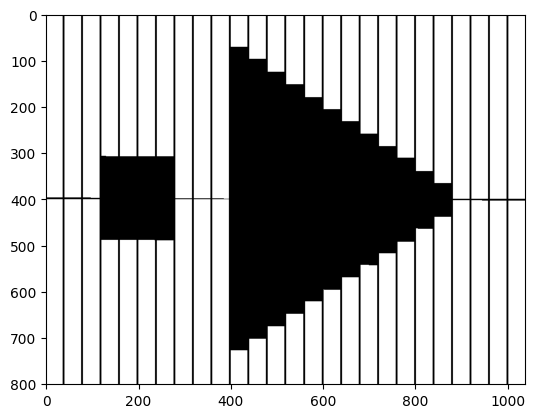

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('mask_output2/MLCv2-Mask_21.pbm')
imgplot = plt.imshow(img)
plt.show()

# Frame Nathan's Masks

In [9]:
import os
from PIL import Image, ImageOps

# Create the directory if it doesn't exist
output_directory = "Nathan's Masks For Opal"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Define the directory and filename of the input image
input_directory = "A:\PBPL\MLCv2-3D-Masks"
input_filename = "MLCv2-Mask_21.pbm"
input_path = os.path.join(input_directory, input_filename)

# Load the original image
original_image = Image.open(input_path)

# Scale the image up by 4
resized_image = original_image.resize((4800, 3200))

# Calculate padding size to make the final image 6000x6000
padding = (6000 - resized_image.width) // 2, (6000 - resized_image.height) // 2

# Add a white border around the image
border_image = ImageOps.expand(resized_image, padding, fill='white')

# Save the bitmap image with border as a .pbm file
border_image.save(os.path.join(output_directory, "MLCv2-Mask21f.pbm"))

# Scale down the image by a factor of 4
scaled_down_image = border_image.resize((border_image.width // 4, border_image.height // 4))

# Save the scaled down image as a .png file
scaled_down_image.save(os.path.join(output_directory, "MLCv2-Mask21f.png"))


# Scale a PBM (Change Resolution)

In [3]:
from PIL import Image, ImageOps
import os

def scale_down_pbm(input_dir, output_dir, filename):
    # Create full input path
    input_path = os.path.join(input_dir, filename)

    # Open the image file
    with Image.open(input_path) as img:
        # Get the current size
        width, height = img.size

        # Scale down the resolution by half
        new_size = (width * 2, height * 2)

        # Resize the image
        new_img = img.resize(new_size, Image.LANCZOS)

        # Create full output path
        output_path = os.path.join(output_dir, 'scaled_up' + filename)

        # Save the new image
        new_img.save(output_path)

# Specify directories and filename
input_directory = 'A:\\PBPL\\'
output_directory = 'A:\\PBPL\\'
filename = 'MLCv2-Mask21f.pbm'

# Call the function
scale_down_pbm(input_directory, output_directory, filename)

# MLCv2 w No Leaf Gaps

In [1]:
import os
import numpy as np
import cv2

##### Function Block #####
#Function to generate an MLC image
def generate_image(leaf, retraction, img): 
    #Fixed mechanical specifications of MLCv2 2D
    leaf_width = 190 #representing 1.9mm
    y_range = 1600 # The leaves have a ~26mm range of motion
    
    x_start = (530 + (leaf - 1)*leaf_width)
    bot_x_start = (530 + (leaf - 27)*leaf_width)
    
    #Write 0s for leaves (y_start : y_stop , x_start : x_stop)
    if leaf <= 26:
        img[400 : int(3000 - retraction*y_range) , x_start : (x_start + leaf_width)] = 0
    elif 27 <= leaf <= 52:
        img[int(3000 + retraction*y_range) : 5600  , bot_x_start : (bot_x_start + leaf_width)] = 0
    else:
        print("Error: Leaf is not in the valid range")
            
    return img
            
#Function to write img as bpm
def save_bitmap(filename, img):
    with open(filename, "w") as f:
        f.write("P1\n6000 6000\n")
        for row in img:
            f.write(" ".join(str(x) for x in row) + "\n")

# Generate corresponding png and scale down by scaling factor
def save_png(filename, img, scale_factor):
    img_scaled = cv2.resize(img, (img.shape[1] // scale_factor, img.shape[0] // scale_factor), interpolation=cv2.INTER_NEAREST)
    img_scaled = (img_scaled == 0) * 255
    cv2.imwrite(filename, img_scaled)

##### Output Destination #####
#Where to save the bpm and png outputs
output_folder = "mask_output"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Parameters
scale_factor = 10    
    
##### Input: Specify Mask #####
#Specify mask with array of 52 entries ranging between 0 and 1 (precision to 4 figures)
#where 0 represents no retraction and 1 represents full retraction
leaf_params = [
    0.000, 0.000, 0.000, 0.250, 0.250, 0.250, 0.250, 0.000, 0.000, 0.000, 
    0.800, 0.740, 0.680, 0.620, 0.560, 0.500, 0.440, 0.380, 0.320, 0.260, 
    0.200, 0.140, 0.080, 0.020, 0.000, 0.000, 
    
    0.000, 0.000, 0.000, 0.250, 0.250, 0.250, 0.250, 0.000, 0.000, 0.000, 
    0.800, 0.740, 0.680, 0.620, 0.560, 0.500, 0.440, 0.380, 0.320, 0.260, 
    0.200, 0.140, 0.080, 0.020, 0.000, 0.000,
]

# Initialize the base image
img = np.zeros((6000, 6000), dtype=np.uint8)
img[400:5600, 530:(530 + 26*190)] = 1

# Apply leaf extensions
for i, retraction in enumerate(leaf_params):
    leaf = i + 1
    generate_image(leaf, retraction, img)

# Save the final image as a bitmap and PNG
bitmap_filename = os.path.join(output_folder, "JohnMask_nogap.pbm")
save_bitmap(bitmap_filename, img)

png_filename = os.path.join(output_folder, "JohnMask_nogap.png")
save_png(png_filename, img, scale_factor)
